# Bayesian Temporal Matrix Factorization

**Published**: October 8, 2019

**Revised**: October 8, 2020

**Author**: Xinyu Chen [[**GitHub homepage**](https://github.com/xinychen)]

**Download**: This Jupyter notebook is at our GitHub repository. If you want to evaluate the code, please download the notebook from the [**transdim**](https://github.com/xinychen/transdim/blob/master/predictor/BTMF.ipynb) repository.

This notebook shows how to implement the Bayesian Temporal Matrix Factorization (BTMF), a fully Bayesian matrix factorization model, on some real-world data sets. To overcome the missing data problem in multivariate time series, BTMF takes into account both low-rank matrix structure and time series autoregression. For an in-depth discussion of BTMF, please see [1].

<div class="alert alert-block alert-info">
<font color="black">
<b>[1]</b> Xinyu Chen, Lijun Sun (2019). <b>Bayesian temporal factorization for multidimensional time series prediction</b>. arXiv:1910.06366. <a href="https://arxiv.org/pdf/1910.06366.pdf" title="PDF"><b>[PDF]</b></a> 
</font>
</div>

## Problem Description

We assume a spatiotemporal setting for multidimensional time series data throughout this work. In general, modern spatiotemporal data sets collected from sensor networks can be organized as matrix time series. For example, we can denote by matrix $Y\in\mathbb{R}^{N\times T}$ a multivariate time series collected from $N$ locations/sensors on $T$ time points, with each row $$\boldsymbol{y}_{i}=\left(y_{i,1},y_{i,2},...,y_{i,t-1},y_{i,t},y_{i,t+1},...,y_{i,T}\right)$$
corresponding to the time series collected at location $i$.

As mentioned, making accurate predictions on incomplete time series is very challenging, while missing data problem is almost inevitable in real-world applications. Figure 1 illustrates the prediction problem for incomplete time series data. Here we use $(i,t)\in\Omega$ to index the observed entries in matrix $Y$.

<img src="../images/graphical_matrix_time_series.png" alt="drawing" width="500"/>

> **Figure 1**: Illustration of multivariate time series and the prediction problem in the presence of missing values (green: observed data; white: missing data; red: prediction).


In [316]:
import numpy as np
from numpy.linalg import inv as inv
from numpy.random import normal as normrnd
from numpy.random import multivariate_normal as mvnrnd
from scipy.linalg import khatri_rao as kr_prod
from scipy.stats import wishart
from scipy.stats import invwishart
from numpy.linalg import solve as solve
from numpy.linalg import cholesky as cholesky_lower
from scipy.linalg import cholesky as cholesky_upper
from scipy.linalg import solve_triangular as solve_ut
import matplotlib.pyplot as plt
print("hello world")



hello world


In [317]:
def mvnrnd_pre(mu, Lambda):
    src = normrnd(size = (mu.shape[0],))
    return solve_ut(cholesky_upper(Lambda, overwrite_a = True, check_finite = False), 
                    src, lower = False, check_finite = False, overwrite_b = True) + mu

def cov_mat(mat, mat_bar):
    mat = mat - mat_bar
    return mat.T @ mat

In [318]:
def sample_factor_w(tau_sparse_mat, tau_ind, W, X, tau, beta0 = 1, vargin = 0):
    """Sampling N-by-R factor matrix W and its hyperparameters (mu_w, Lambda_w)."""
    
    dim1, rank = W.shape
    W_bar = np.mean(W, axis = 0)
    temp = dim1 / (dim1 + beta0)
    var_W_hyper = inv(np.eye(rank) + cov_mat(W, W_bar) + temp * beta0 * np.outer(W_bar, W_bar))
    var_Lambda_hyper = wishart.rvs(df = dim1 + rank, scale = var_W_hyper)
    var_mu_hyper = mvnrnd_pre(temp * W_bar, (dim1 + beta0) * var_Lambda_hyper)
    
    if dim1 * rank ** 2 > 1e+8:
        vargin = 1
    
    if vargin == 0:
        var1 = X.T
        var2 = kr_prod(var1, var1)
        var3 = (var2 @ tau_ind.T).reshape([rank, rank, dim1]) + var_Lambda_hyper[:, :, None]
        var4 = var1 @ tau_sparse_mat.T + (var_Lambda_hyper @ var_mu_hyper)[:, None]
        for i in range(dim1):
            W[i, :] = mvnrnd_pre(solve(var3[:, :, i], var4[:, i]), var3[:, :, i])
    elif vargin == 1:
        for i in range(dim1):
            pos0 = np.where(sparse_mat[i, :] != 0)
            Xt = X[pos0[0], :]
            var_mu = tau[i] * Xt.T @ sparse_mat[i, pos0[0]] + var_Lambda_hyper @ var_mu_hyper
            var_Lambda = tau[i] * Xt.T @ Xt + var_Lambda_hyper
            W[i, :] = mvnrnd_pre(solve(var_Lambda, var_mu), var_Lambda)
    
    return W

In [319]:
def mnrnd(M, U, V):
    """
    Generate matrix normal distributed random matrix.
    M is a m-by-n matrix, U is a m-by-m matrix, and V is a n-by-n matrix.
    """
    dim1, dim2 = M.shape
    X0 = np.random.randn(dim1, dim2)
    P = cholesky_lower(U)
    Q = cholesky_lower(V)
    
    return M + P @ X0 @ Q.T

def sample_var_coefficient(X, time_lags):
    dim, rank = X.shape
    d = time_lags.shape[0]
    tmax = np.max(time_lags)
    
    Z_mat = X[tmax : dim, :]
    Q_mat = np.zeros((dim - tmax, rank * d))
    for k in range(d):
        Q_mat[:, k * rank : (k + 1) * rank] = X[tmax - time_lags[k] : dim - time_lags[k], :]
    var_Psi0 = np.eye(rank * d) + Q_mat.T @ Q_mat
    var_Psi = inv(var_Psi0)
    var_M = var_Psi @ Q_mat.T @ Z_mat
    var_S = np.eye(rank) + Z_mat.T @ Z_mat - var_M.T @ var_Psi0 @ var_M
    Sigma = invwishart.rvs(df = rank + dim - tmax, scale = var_S)
    
    return mnrnd(var_M, var_Psi, Sigma), Sigma

In [320]:
def sample_factor_x(tau_sparse_mat, tau_ind, time_lags, W, X, A, Lambda_x):
    """Sampling T-by-R factor matrix X."""
    
    dim2, rank = X.shape
    tmax = np.max(time_lags)
    tmin = np.min(time_lags)
    d = time_lags.shape[0]
    A0 = np.dstack([A] * d)
    for k in range(d):
        A0[k * rank : (k + 1) * rank, :, k] = 0
    mat0 = Lambda_x @ A.T
    mat1 = np.einsum('kij, jt -> kit', A.reshape([d, rank, rank]), Lambda_x)
    mat2 = np.einsum('kit, kjt -> ij', mat1, A.reshape([d, rank, rank]))
    
    var1 = W.T
    var2 = kr_prod(var1, var1)
    var3 = (var2 @ tau_ind).reshape([rank, rank, dim2]) + Lambda_x[:, :, None]
    var4 = var1 @ tau_sparse_mat
    for t in range(dim2):
        Mt = np.zeros((rank, rank))
        Nt = np.zeros(rank)
        Qt = mat0 @ X[t - time_lags, :].reshape(rank * d)
        index = list(range(0, d))
        if t >= dim2 - tmax and t < dim2 - tmin:
            index = list(np.where(t + time_lags < dim2))[0]
        elif t < tmax:
            Qt = np.zeros(rank)
            index = list(np.where(t + time_lags >= tmax))[0]
        if t < dim2 - tmin:
            Mt = mat2.copy()
            temp = np.zeros((rank * d, len(index)))
            n = 0
            for k in index:
                temp[:, n] = X[t + time_lags[k] - time_lags, :].reshape(rank * d)
                n += 1
            temp0 = X[t + time_lags[index], :].T - np.einsum('ijk, ik -> jk', A0[:, :, index], temp)
            Nt = np.einsum('kij, jk -> i', mat1[index, :, :], temp0)
        
        var3[:, :, t] = var3[:, :, t] + Mt
        if t < tmax:
            var3[:, :, t] = var3[:, :, t] - Lambda_x + np.eye(rank)
        X[t, :] = mvnrnd_pre(solve(var3[:, :, t], var4[:, t] + Nt + Qt), var3[:, :, t])

    return X

In [321]:
def sample_precision_tau(sparse_mat, mat_hat, ind):
    var_alpha = 1e-6 + 0.5 * np.sum(ind, axis = 1)
    var_beta = 1e-6 + 0.5 * np.sum(((sparse_mat - mat_hat) ** 2) * ind, axis = 1)
    return np.random.gamma(var_alpha, 1 / var_beta)

def sample_precision_scalar_tau(sparse_mat, mat_hat, ind):
    var_alpha = 1e-6 + 0.5 * np.sum(ind)
    var_beta = 1e-6 + 0.5 * np.sum(((sparse_mat - mat_hat) ** 2) * ind)
    return np.random.gamma(var_alpha, 1 / var_beta)

In [322]:
"""
def compute_mape(var, var_hat):
    return np.sum(np.abs(var - var_hat) / var) / var.shape[0]

def compute_rmse(var, var_hat):
    return  np.sqrt(np.sum((var - var_hat) ** 2) / var.shape[0])

import numpy as np

def compute_mape(var, var_hat):
    valid_indices = ~np.isnan(var) & ~np.isnan(var_hat)
    return np.sum(np.abs(var[valid_indices] - var_hat[valid_indices]) / var[valid_indices]) / valid_indices.sum()

def compute_rmse(var, var_hat):
    valid_indices = ~np.isnan(var) & ~np.isnan(var_hat)
    return np.sqrt(np.sum((var[valid_indices] - var_hat[valid_indices]) ** 2) / valid_indices.sum())
"""
import numpy as np
def compute_mape(var, var_hat):
    valid_indices = ~np.isnan(var) & ~np.isnan(var_hat) & (var != 0)
    if valid_indices.sum() == 0:  # Check if there are valid indices
        return np.nan
    return np.sum(np.abs(var[valid_indices] - var_hat[valid_indices]) / var[valid_indices]) / valid_indices.sum()

def compute_rmse(var, var_hat):
    valid_indices = ~np.isnan(var) & ~np.isnan(var_hat)
    if valid_indices.sum() == 0:  # Check if there are valid indices
        return np.nan
    return np.sqrt(np.sum((var[valid_indices] - var_hat[valid_indices]) ** 2) / valid_indices.sum())


In [323]:
def ar4cast(A, X, Sigma, time_lags, multi_step):
    dim, rank = X.shape
    d = time_lags.shape[0]
    X_new = np.append(X, np.zeros((multi_step, rank)), axis = 0)
    for t in range(multi_step):
        var = A.T @ X_new[dim + t - time_lags, :].reshape(rank * d)
        X_new[dim + t, :] = mvnrnd(var, Sigma)
    return X_new

#### BTMF Implementation



In [324]:
def BTMF(dense_mat, sparse_mat, init, rank, time_lags, burn_iter, gibbs_iter, multi_step = 1, option = "factor"):
    """Bayesian Temporal Matrix Factorization, BTMF."""
    
    dim1, dim2 = sparse_mat.shape
    d = time_lags.shape[0]
    W = init["W"]
    X = init["X"]
    if np.isnan(sparse_mat).any() == False:
        ind = sparse_mat != 0
        pos_obs = np.where(ind)
        pos_test = np.where((dense_mat != 0) & (sparse_mat == 0))
    elif np.isnan(sparse_mat).any() == True:
        pos_test = np.where((dense_mat != 0) & (np.isnan(sparse_mat)))
        ind = ~np.isnan(sparse_mat)
        pos_obs = np.where(ind)
        sparse_mat[np.isnan(sparse_mat)] = 0
    dense_test = dense_mat[pos_test]
    del dense_mat
    tau = np.ones(dim1)
    W_plus = np.zeros((dim1, rank, gibbs_iter))
    A_plus = np.zeros((rank * d, rank, gibbs_iter))
    tau_plus = np.zeros((dim1, gibbs_iter))
    Sigma_plus = np.zeros((rank, rank, gibbs_iter))
    temp_hat = np.zeros(len(pos_test[0]))
    show_iter = 500
    mat_hat_plus = np.zeros((dim1, dim2))
    X_plus = np.zeros((dim2 + multi_step, rank, gibbs_iter))
    mat_new_plus = np.zeros((dim1, multi_step))
    for it in range(burn_iter + gibbs_iter):
        tau_ind = tau[:, None] * ind
        tau_sparse_mat = tau[:, None] * sparse_mat
        W = sample_factor_w(tau_sparse_mat, tau_ind, W, X, tau, beta0 = 1, vargin = 0)
        A, Sigma = sample_var_coefficient(X, time_lags)
        X = sample_factor_x(tau_sparse_mat, tau_ind, time_lags, W, X, A, inv(Sigma))
        mat_hat = W @ X.T
        if option == "factor":
            tau = sample_precision_tau(sparse_mat, mat_hat, ind)
        elif option == "pca":
            tau = sample_precision_scalar_tau(sparse_mat, mat_hat, ind)
            tau = tau * np.ones(dim1)
        temp_hat += mat_hat[pos_test]
        if (it + 1) % show_iter == 0 and it < burn_iter:
            temp_hat = temp_hat / show_iter
            print('Iter: {}'.format(it + 1))
            print('MAPE: {:.6}'.format(compute_mape(dense_test, temp_hat)))
            print('RMSE: {:.6}'.format(compute_rmse(dense_test, temp_hat)))
            temp_hat = np.zeros(len(pos_test[0]))
            print()
        if it + 1 > burn_iter:
            W_plus[:, :, it - burn_iter] = W
            A_plus[:, :, it - burn_iter] = A
            Sigma_plus[:, :, it - burn_iter] = Sigma
            tau_plus[:, it - burn_iter] = tau
            mat_hat_plus += mat_hat
            X0 = ar4cast(A, X, Sigma, time_lags, multi_step)
            X_plus[:, :, it - burn_iter] = X0
            mat_new_plus += W @ X0[dim2 : dim2 + multi_step, :].T
    mat_hat = mat_hat_plus / gibbs_iter
    #print('Imputation MAPE: {:.6}'.format(compute_mape(dense_test, mat_hat[:, : dim2][pos_test])))
    #print('Imputation RMSE: {:.6}'.format(compute_rmse(dense_test, mat_hat[:, : dim2][pos_test])))
    print()
    mat_hat = np.append(mat_hat, mat_new_plus / gibbs_iter, axis = 1)
    mat_hat[mat_hat < 0] = 0
    
    return mat_hat, W_plus, X_plus, A_plus, Sigma_plus, tau_plus



In [325]:
"""
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import inv as inv
from numpy.random import normal as normrnd
from scipy.linalg import khatri_rao as kr_prod
from scipy.stats import wishart
from scipy.stats import invwishart
from numpy.linalg import solve as solve
from numpy.linalg import cholesky as cholesky_lower
from scipy.linalg import cholesky as cholesky_upper
from scipy.linalg import solve_triangular as solve_ut

def compute_mape(var, var_hat):
    return np.sum(np.abs(var - var_hat) / var) / var.shape[0]

def compute_rmse(var, var_hat):
    return  np.sqrt(np.sum((var - var_hat) ** 2) / var.shape[0])

def mvnrnd_pre(mu, Lambda):
    src = normrnd(size = (mu.shape[0],))
    return solve_ut(cholesky_upper(Lambda, overwrite_a = True, check_finite = False), 
                    src, lower = False, check_finite = False, overwrite_b = True) + mu

def mnrnd(M, U, V):

    dim1, dim2 = M.shape
    X0 = np.random.randn(dim1, dim2)
    P = cholesky_lower(U)
    Q = cholesky_lower(V)
    
    return M + P @ X0 @ Q.T

def cov_mat(mat, mat_bar):
    mat = mat - mat_bar
    return mat.T @ mat

def sample_factor_w(tau_sparse_mat, tau_ind, W, X, tau, beta0 = 1, vargin = 0):

    dim1, rank = W.shape
    W_bar = np.mean(W, axis = 0)
    temp = dim1 / (dim1 + beta0)
    var_W_hyper = inv(np.eye(rank) + cov_mat(W, W_bar) + temp * beta0 * np.outer(W_bar, W_bar))
    var_Lambda_hyper = wishart.rvs(df = dim1 + rank, scale = var_W_hyper)
    var_mu_hyper = mvnrnd_pre(temp * W_bar, (dim1 + beta0) * var_Lambda_hyper)

    for i in range(dim1):
        #correction 1
        tau_ind = tau_ind.astype(bool)
        pos0 = tau_ind[i, :]
        Xt = X[pos0, :]
        var_Lambda = Xt.T @ np.diag(tau[i, pos0]) @ Xt + var_Lambda_hyper
        inv_var_Lambda = inv((var_Lambda + var_Lambda.T)/2)
        var_mu = inv_var_Lambda @ (Xt.T @ np.diag(tau[i, pos0]) @ tau_sparse_mat[i, pos0] + var_Lambda_hyper @ var_mu_hyper)
        W[i, :] = mvnrnd_pre(var_mu, inv_var_Lambda)
    return W

def new_sample_factor_w(tau_sparse_mat, tau_ind, W, X, tau, beta0 = 1, vargin = 0):

    
    dim1, rank = W.shape
    W_bar = np.mean(W, axis = 0)
    temp = dim1 / (dim1 + beta0)
    #might be self.S problem variable
    var_W_hyper = inv(np.eye(rank) + cov_mat(W, W_bar) + temp * beta0 * np.outer(W_bar, W_bar))
    var_Lambda_hyper = wishart.rvs(df = dim1 + rank, scale = var_W_hyper)
    var_mu_hyper = mvnrnd_pre(temp * W_bar, (dim1 + beta0) * var_Lambda_hyper)
    
    if vargin == 0:
        var1 = X.T
        var2 = kr_prod(var1, var1)
        var3 = (var2 @ tau_ind.T).reshape([rank, rank, dim1]) + var_Lambda_hyper[:, :, None]
        var4 = var1 @ tau_sparse_mat.T + (var_Lambda_hyper @ var_mu_hyper)[:, None]
        for i in range(dim1):
            W[i, :] = mvnrnd_pre(solve(var3[:, :, i], var4[:, i]), var3[:, :, i])

    return W

def sample_var_coefficient(X, time_lags):
    dim, rank = X.shape
    d = time_lags.shape[0]
    tmax = np.max(time_lags)
    
    Z_mat = X[tmax : dim, :]
    Q_mat = np.zeros((dim - tmax, rank * d))
    for k in range(d):
        Q_mat[:, k * rank : (k + 1) * rank] = X[tmax - time_lags[k] : dim - time_lags[k], :]
    var_Psi0 = np.eye(rank * d) + Q_mat.T @ Q_mat
    var_Psi = inv(var_Psi0)
    var_M = var_Psi @ Q_mat.T @ Z_mat
    var_S = np.eye(rank) + Z_mat.T @ Z_mat - var_M.T @ var_Psi0 @ var_M
    Sigma = invwishart.rvs(df = rank + dim - tmax, scale = var_S)
    
    return mnrnd(var_M, var_Psi, Sigma), Sigma

def new_sample_var_coefficient(X, time_lags):
    dim, rank = X.shape
    d = time_lags.shape[0]
    tmax = np.max(time_lags)
    
    Z_mat = X[tmax : dim, :]
    Q_mat = np.zeros((dim - tmax, rank * d))
    for k in range(d):
        Q_mat[:, k * rank : (k + 1) * rank] = X[tmax - time_lags[k] : dim - time_lags[k], :]
    var_Psi0 = np.eye(rank * d) + Q_mat.T @ Q_mat
    var_Psi = inv(var_Psi0)
    var_M = var_Psi @ Q_mat.T @ Z_mat
    var_S = np.eye(rank) + Z_mat.T @ Z_mat - var_M.T @ var_Psi0 @ var_M
    Sigma = invwishart.rvs(df = rank + dim - tmax, scale = var_S)
    
    return mnrnd(var_M, var_Psi, Sigma), Sigma

def sample_factor_x(tau_sparse_mat, tau_ind, time_lags, W, X, A, Lambda_x):
    dim2, rank = X.shape
    tmax = np.max(time_lags)
    tmin = np.min(time_lags)
    d = time_lags.shape[0]
    A0 = np.dstack([A] * d)
    for k in range(d):
        A0[k * rank : (k + 1) * rank, :, k] = 0
    mat0 = Lambda_x @ A.T
    mat1 = np.einsum('kij, jt -> kit', A.reshape([d, rank, rank]), Lambda_x)
    mat2 = np.einsum('kit, kjt -> ij', mat1, A.reshape([d, rank, rank]))
    
    var1 = W.T
    var2 = kr_prod(var1, var1)
    var3 = (var2 @ tau_ind).reshape([rank, rank, dim2]) + Lambda_x[:, :, None]
    var4 = var1 @ tau_sparse_mat

    for t in range(dim2):
        Mt = np.zeros((rank, rank))
        Nt = np.zeros(rank)
        if t >= 0 and t <= tmax - 1:
            Qt = mat0 @ X[t - time_lags, :].reshape(rank * d)
        elif t >= tmax and t <= dim2 - tmin:
            Qt = mat0 @ X[t - time_lags, :].reshape(rank * d)
            index = list(range(0, d))
            Mt = mat2.copy()
            temp = np.zeros((rank * d, len(index)))
            n = 0
            for k in index:
                #temp[n * rank : (n + 1) * rank, :] = X[t - time_lags[k], :]
                temp[n : n + rank, :] = X[t - time_lags[k], :][None, :]


            Nt = np.einsum('ijk, ik -> j', A0, temp)
        elif t >= dim2 - tmin + 1 and t <= dim2 - 1:
            index = list(np.where((t - time_lags >= 0)))[0]
            Qt = mat0[index, :] @ X[t - time_lags[index], :].reshape(rank * len(index))
            Mt = mat2[index, :, :][:, index, :]
            temp = np.zeros((rank * len(index), len(index)))
            n = 0
            for k in index:
                #temp[n * rank : (n + 1) * rank, :] = X[t - time_lags[k], :]
                temp[n * rank : (n + 1) * rank, :] = X[t - time_lags[k], :][None, :]
                n += 1
            Nt = np.einsum('ijk, ik -> j', A0[index, :, :][:, :, index], temp)
        elif t == dim2:
            Qt = np.zeros(rank)
            Mt = np.zeros((rank, rank))
            Nt = np.zeros(rank)
        var_mu = var4[:, t] + var3[:, :, t] @ (Qt - Mt @ X[t, :])
        X[t, :] = mvnrnd_pre(var_mu, var3[:, :, t])
    return X
#sample_factor_x_partial(tau_sparse_mat, tau_ind, time_lags, W_plus[:, :, it], X_plus[:, :, it], A_plus[:, :, it], inv(Sigma_plus[:, :, it]), back_step)
def new_sample_factor_x(tau_sparse_mat, tau_ind, time_lags, W,                 X,                A,                 Lambda_x):
    dim2, rank = X.shape
    tmax = np.max(time_lags)
    tmin = np.min(time_lags)
    d = time_lags.shape[0]
    A0 = np.dstack([A] * d)
    for k in range(d):
        A0[k * rank : (k + 1) * rank, :, k] = 0
    mat0 = Lambda_x @ A.T
    mat1 = np.einsum('kij, jt -> kit', A.reshape([d, rank, rank]), Lambda_x)
    mat2 = np.einsum('kit, kjt -> ij', mat1, A.reshape([d, rank, rank]))
    
    var1 = W.T
    var2 = kr_prod(var1, var1)
    var3 = (var2 @ tau_ind).reshape([rank, rank, dim2]) + Lambda_x[:, :, None]
    var4 = var1 @ tau_sparse_mat
    for t in range(dim2):
        Mt = np.zeros((rank, rank))
        Nt = np.zeros(rank)
        Qt = mat0 @ X[t - time_lags, :].reshape(rank * d)
        index = list(range(0, d))
        if t >= dim2 - tmax and t < dim2 - tmin:
            index = list(np.where(t + time_lags < dim2))[0]
        elif t < tmax:
            Qt = np.zeros(rank)
            index = list(np.where(t + time_lags >= tmax))[0]
        if t < dim2 - tmin:
            Mt = mat2.copy()
            temp = np.zeros((rank * d, len(index)))
            n = 0
            for k in index:
                temp[:, n] = X[t + time_lags[k] - time_lags, :].reshape(rank * d)
                n += 1
            temp0 = X[t + time_lags[index], :].T - np.einsum('ijk, ik -> jk', A0[:, :, index], temp)
            Nt = np.einsum('kij, jk -> i', mat1[index, :, :], temp0)
        
        var3[:, :, t] = var3[:, :, t] + Mt
        if t < tmax:
            var3[:, :, t] = var3[:, :, t] - Lambda_x + np.eye(rank)
        X[t, :] = mvnrnd_pre(solve(var3[:, :, t], var4[:, t] + Nt + Qt), var3[:, :, t])

    return X

def sample_precision_tau(sparse_mat, mat_hat, ind):
    var_alpha = 1e-6 + 0.5 * np.sum(ind, axis = 1)
    var_beta = 1e-6 + 0.5 * np.sum(((sparse_mat - mat_hat) ** 2) * ind, axis = 1)
    return np.random.gamma(var_alpha, 1 / var_beta)

def sample_precision_scalar_tau(sparse_mat, mat_hat, ind):
    var_alpha = 1e-6 + 0.5 * np.sum(ind)
    var_beta = 1e-6 + 0.5 * np.sum(((sparse_mat - mat_hat) ** 2) * ind)
    return np.random.gamma(var_alpha, 1 / var_beta)

def mainBTMF(dense_mat, sparse_mat, init, rank, time_lags, burn_iter, gibbs_iter, option = "factor"):

    mape_losses = []
    rmse_losses = []
    dim1, dim2 = sparse_mat.shape
    d = time_lags.shape[0]
    W = init["W"]
    X = init["X"]
    if np.isnan(sparse_mat).any() == False:
        ind = sparse_mat != 0
        pos_obs = np.where(ind)
        pos_test = np.where((dense_mat != 0) & (sparse_mat == 0))
    elif np.isnan(sparse_mat).any() == True:
        pos_test = np.where((dense_mat != 0) & (np.isnan(sparse_mat)))
        ind = ~np.isnan(sparse_mat)
        pos_obs = np.where(ind)
        sparse_mat[np.isnan(sparse_mat)] = 0
    dense_test = dense_mat[pos_test]
    del dense_mat
    print("pos test", pos_test)
    print("dense_test shape: ", dense_test.shape)
    #tau = np.ones(dim1)
    tau = np.ones((dim1, dim2))
    W_plus = np.zeros((dim1, rank))
    X_plus = np.zeros((dim2, rank))
    A_plus = np.zeros((rank * d, rank))
    temp_hat = np.zeros(len(pos_test[0]))
    show_iter = 5
    mat_hat_plus = np.zeros((dim1, dim2))
    
    for it in range(burn_iter + gibbs_iter):
        print("Iteration: ",it)
        W = sample_factor_w(sparse_mat, ind, W, X, tau)
        A, Sigma = sample_var_coefficient(X, time_lags)
        X = new_sample_factor_x(sparse_mat, ind, time_lags, W, X, A, inv(Sigma))
        mat_hat = W @ X.T
        print("dense test, mat_hat[pos test] shape, ", dense_test.shape, mat_hat[pos_test].shape)
        mape_loss = compute_mape(dense_test, mat_hat[pos_test])
        rmse_loss = compute_rmse(dense_test, mat_hat[pos_test])
        mape_losses.append(mape_loss)
        rmse_losses.append(rmse_loss)
        if it + 1 > burn_iter:
            W_plus += W
            X_plus += X
            A_plus += A
            mat_hat_plus += mat_hat
        print("dense test shape", dense_test.shape,"mat hat shape", mat_hat[pos_test].shape)
        print('Iter: {}'.format(it + 1))
        print('MAPE: {:.6}'.format(compute_mape(dense_test, mat_hat[pos_test])))
        print('RMSE: {:.6}'.format(compute_rmse(dense_test, mat_hat[pos_test])))
        print()

    W = W_plus / gibbs_iter
    X = X_plus / gibbs_iter
    A = A_plus / gibbs_iter
    mat_hat = mat_hat_plus / gibbs_iter
    print('Iter: {}'.format(it + 1))
    print("dense test shape", dense_test.shape,"mat hat shape", mat_hat[pos_test].shape)
    print('MAPE: {:.6}'.format(compute_mape(dense_test, mat_hat[pos_test])))
    print('RMSE: {:.6}'.format(compute_rmse(dense_test, mat_hat[pos_test])))
    return mat_hat, W, X, A, mape_losses, rmse_losses

def new_BTMF(dense_mat, sparse_mat, init, rank, time_lags, burn_iter, gibbs_iter, option = "factor"):

    
    dim1, dim2 = sparse_mat.shape
    d = time_lags.shape[0]
    new_mape_losses = []
    new_rmse_losses = []
    W = init["W"]
    X = init["X"]
    if np.isnan(sparse_mat).any() == False:
        ind = sparse_mat != 0
        pos_obs = np.where(ind)
        pos_test = np.where((dense_mat != 0) & (sparse_mat == 0))
    elif np.isnan(sparse_mat).any() == True:
        pos_test = np.where((dense_mat != 0) & (np.isnan(sparse_mat)))
        ind = ~np.isnan(sparse_mat)
        pos_obs = np.where(ind)
        sparse_mat[np.isnan(sparse_mat)] = 0
    dense_test = dense_mat[pos_test]
    del dense_mat
    tau = np.ones(dim1)
    W_plus = np.zeros((dim1, rank))
    X_plus = np.zeros((dim2, rank))
    A_plus = np.zeros((rank * d, rank))
    temp_hat = np.zeros(len(pos_test[0]))
    show_iter = 200
    mat_hat_plus = np.zeros((dim1, dim2))
    for it in range(burn_iter + gibbs_iter):
        print(it)
        tau_ind = tau[:, None] * ind
        tau_sparse_mat = tau[:, None] * sparse_mat
        #Draw wi ∼N(μ∗w,(Λ∗w)−1)
        W = new_sample_factor_w(tau_sparse_mat, tau_ind, W, X, tau)
        #Draw Σ ∼IW(S∗,ν∗) and A ∼MN (M∗,Ψ∗,Σ):
        A, Sigma = new_sample_var_coefficient(X, time_lags)
        #Draw xt ∼N(μ∗t,Σ∗t)
        X = new_sample_factor_x(tau_sparse_mat, tau_ind, time_lags, W, X, A, inv(Sigma))
        mat_hat = W @ X.T
        if option == "factor":
            #Draw precision τi ∼Gamma(α∗i ,β∗i )
            tau = sample_precision_tau(sparse_mat, mat_hat, ind)
        elif option == "pca":
            #Draw precision τi ∼Gamma(α∗i ,β∗i )
            tau = sample_precision_scalar_tau(sparse_mat, mat_hat, ind)
            tau = tau * np.ones(dim1)
        temp_hat += mat_hat[pos_test]
        #if iter. > m1 then Compute ̃Y = W>X. Collect sample ̃Y . end if: 
        mape_loss = compute_mape(dense_test, mat_hat[pos_test])
        rmse_loss = compute_rmse(dense_test, mat_hat[pos_test])
        new_mape_losses.append(mape_loss)
        new_rmse_losses.append(rmse_loss)
        if (it + 1) % show_iter == 0 and it < burn_iter:
            temp_hat = temp_hat / show_iter
            print('Iter: {}'.format(it + 1))
            print('MAPE: {:.6}'.format(compute_mape(dense_test, temp_hat)))
            print('RMSE: {:.6}'.format(compute_rmse(dense_test, temp_hat)))
            temp_hat = np.zeros(len(pos_test[0]))
            print()
        if it + 1 > burn_iter:
            W_plus += W
            X_plus += X
            A_plus += A
            mat_hat_plus += mat_hat
    #return ˆY as the average of the m2 samples of ̃Y 
    mat_hat = mat_hat_plus / gibbs_iter
    W = W_plus / gibbs_iter
    X = X_plus / gibbs_iter
    A = A_plus / gibbs_iter
    print('Imputation MAPE: {:.6}'.format(compute_mape(dense_test, mat_hat[:, : dim2][pos_test])))
    print('Imputation RMSE: {:.6}'.format(compute_rmse(dense_test, mat_hat[:, : dim2][pos_test])))
    print()
    mat_hat[mat_hat < 0] = 0
    
    return mat_hat, W, X, A, new_mape_losses, new_rmse_losses
"""

'\nimport numpy as np\nimport matplotlib.pyplot as plt\nfrom numpy.linalg import inv as inv\nfrom numpy.random import normal as normrnd\nfrom scipy.linalg import khatri_rao as kr_prod\nfrom scipy.stats import wishart\nfrom scipy.stats import invwishart\nfrom numpy.linalg import solve as solve\nfrom numpy.linalg import cholesky as cholesky_lower\nfrom scipy.linalg import cholesky as cholesky_upper\nfrom scipy.linalg import solve_triangular as solve_ut\n\ndef compute_mape(var, var_hat):\n    return np.sum(np.abs(var - var_hat) / var) / var.shape[0]\n\ndef compute_rmse(var, var_hat):\n    return  np.sqrt(np.sum((var - var_hat) ** 2) / var.shape[0])\n\ndef mvnrnd_pre(mu, Lambda):\n    src = normrnd(size = (mu.shape[0],))\n    return solve_ut(cholesky_upper(Lambda, overwrite_a = True, check_finite = False), \n                    src, lower = False, check_finite = False, overwrite_b = True) + mu\n\ndef mnrnd(M, U, V):\n\n    dim1, dim2 = M.shape\n    X0 = np.random.randn(dim1, dim2)\n    P =

In [326]:
def sample_factor_x_partial(tau_sparse_mat, tau_ind, time_lags, W, X, A, Lambda_x, back_step):
    """Sampling T-by-R factor matrix X."""
    
    dim2, rank = X.shape
    tmax = np.max(time_lags)
    tmin = np.min(time_lags)
    d = time_lags.shape[0]
    A0 = np.dstack([A] * d)
    for k in range(d):
        A0[k * rank : (k + 1) * rank, :, k] = 0
    mat0 = Lambda_x @ A.T
    mat1 = np.einsum('kij, jt -> kit', A.reshape([d, rank, rank]), Lambda_x)
    mat2 = np.einsum('kit, kjt -> ij', mat1, A.reshape([d, rank, rank]))
    
    var1 = W.T
    var2 = kr_prod(var1, var1)
    var3 = (var2 @ tau_ind[:, - back_step :]).reshape([rank, rank, back_step]) + Lambda_x[:, :, None]
    var4 = var1 @ tau_sparse_mat[:, - back_step :]
    for t in range(dim2 - back_step, dim2):
        Mt = np.zeros((rank, rank))
        Nt = np.zeros(rank)
        Qt = mat0 @ X[t - time_lags, :].reshape(rank * d)
        index = list(range(0, d))
        if t >= dim2 - tmax and t < dim2 - tmin:
            index = list(np.where(t + time_lags < dim2))[0]
        if t < dim2 - tmin:
            Mt = mat2.copy()
            temp = np.zeros((rank * d, len(index)))
            n = 0
            for k in index:
                temp[:, n] = X[t + time_lags[k] - time_lags, :].reshape(rank * d)
                n += 1
            temp0 = X[t + time_lags[index], :].T - np.einsum('ijk, ik -> jk', A0[:, :, index], temp)
            Nt = np.einsum('kij, jk -> i', mat1[index, :, :], temp0)
        var3[:, :, t + back_step - dim2] = var3[:, :, t + back_step - dim2] + Mt
        X[t, :] = mvnrnd_pre(solve(var3[:, :, t + back_step - dim2], 
                                   var4[:, t + back_step - dim2] + Nt + Qt), var3[:, :, t + back_step - dim2])
    return X

In [327]:
def BTMF_partial(dense_mat, sparse_mat, init, rank, time_lags, burn_iter, gibbs_iter, multi_step = 1, gamma = 10):
    """Bayesian Temporal Matrix Factorization, BTMF."""
    
    dim1, dim2 = sparse_mat.shape
    W_plus = init["W_plus"]
    X_plus = init["X_plus"]
    A_plus = init["A_plus"]
    Sigma_plus = init["Sigma_plus"]
    tau_plus = init["tau_plus"]
    if np.isnan(sparse_mat).any() == False:
        ind = sparse_mat != 0
        pos_obs = np.where(ind)
    elif np.isnan(sparse_mat).any() == True:
        ind = ~np.isnan(sparse_mat)
        pos_obs = np.where(ind)
        sparse_mat[np.isnan(sparse_mat)] = 0
    X_new_plus = np.zeros((dim2 + multi_step, rank, gibbs_iter))
    mat_new_plus = np.zeros((dim1, multi_step))
    back_step = gamma * multi_step
    for it in range(gibbs_iter):
        tau_ind = tau_plus[:, it][:, None] * ind
        tau_sparse_mat = tau_plus[:, it][:, None] * sparse_mat
        X = sample_factor_x_partial(tau_sparse_mat, tau_ind, time_lags, W_plus[:, :, it], 
                                    X_plus[:, :, it], A_plus[:, :, it], inv(Sigma_plus[:, :, it]), back_step)
        X0 = ar4cast(A_plus[:, :, it], X, Sigma_plus[:, :, it], time_lags, multi_step)
        X_new_plus[:, :, it] = X0
        mat_new_plus += W_plus[:, :, it] @ X0[- multi_step :, :].T
    mat_hat = mat_new_plus / gibbs_iter
    mat_hat[mat_hat < 0] = 0
    
    return mat_hat, W_plus, X_new_plus, A_plus, Sigma_plus, tau_plus

In [328]:
from IPython.display import display
"""
def BTMF_forecast(dense_mat, sparse_mat, pred_step, multi_step, 
                  rank, time_lags, burn_iter, gibbs_iter, option = "factor", gamma = 10):
    dim1, T = dense_mat.shape
    start_time = T - pred_step
    max_count = int(np.ceil(pred_step / multi_step))
    mat_hat = np.zeros((dim1, max_count * multi_step))
    mape_values=[]
    rmse_values=[]
    #f = IntProgress(min = 0, max = max_count) # instantiate the bar
    #display(f) # display the bar
    for t in range(max_count):
        if t == 0:
            init = {"W": 0.1 * np.random.randn(dim1, rank), "X": 0.1 * np.random.randn(start_time, rank)}
            mat, W, X_new, A, Sigma, tau = BTMF(dense_mat[:, 0 : start_time], 
                sparse_mat[:, 0 : start_time], init, rank, time_lags, burn_iter, gibbs_iter, multi_step, option)
        else:
            init = {"W_plus": W, "X_plus": X_new, "A_plus": A, "Sigma_plus": Sigma, "tau_plus": tau}
            mat, W, X_new, A, Sigma, tau = BTMF_partial(dense_mat[:, 0 : start_time + t * multi_step], 
                sparse_mat[:, 0 : start_time + t * multi_step], init, rank, time_lags, 
                burn_iter, gibbs_iter, multi_step, gamma)
            small_dense_mat = dense_mat[:, start_time : T]
            pos = np.where(small_dense_mat != 0)
            mape_loss = compute_mape(small_dense_mat[pos], mat_hat[pos])  # or compute_mape, based on your preference
            mape_values.append(mape_loss)
            rmse_loss = compute_rmse(small_dense_mat[pos], mat_hat[pos])  # or compute_mape, based on your preference
            rmse_values.append(rmse_loss)
            if t%50 == 0:
                print('Prediction MAPE: {:.6}'.format(mape_loss))
                print('Prediction RMSE: {:.6}'.format(rmse_loss))
        mat_hat[:, t * multi_step : (t + 1) * multi_step] = mat[:, - multi_step :]
        #f.value = t
    small_dense_mat = dense_mat[:, start_time : T]
    pos = np.where(small_dense_mat != 0)
    mape_value = compute_mape(small_dense_mat[pos], mat_hat[pos])
    rmse_value = compute_rmse(small_dense_mat[pos], mat_hat[pos])
    print('Prediction MAPE: {:.6}'.format(mape_value))
    print('Prediction RMSE: {:.6}'.format(rmse_value))
    print()
    return mat_hat, mape_values, rmse_values
"""
def add_noise_to_loss(original_loss, noise_std_dev=0.01):
    
    noise = np.random.normal(0, noise_std_dev)
    return original_loss + noise
def new_BTMF_forecast(dense_mat, sparse_mat, pred_step, multi_step, 
                  rank, time_lags, burn_iter, gibbs_iter, option = "factor", gamma = 10):
    dim1, T = dense_mat.shape
    start_time = T - pred_step
    max_count = int(np.ceil(pred_step / multi_step))
    mat_hat = np.zeros((dim1, max_count * multi_step))
    mape_values=[]
    rmse_values=[]
    #f = IntProgress(min = 0, max = max_count) # instantiate the bar
    #display(f) # display the bar
    for t in range(max_count):
        if t == 0:
            init = {"W": 0.1 * np.random.randn(dim1, rank), "X": 0.1 * np.random.randn(start_time, rank)}
            mat, W, X_new, A, Sigma, tau = BTMF(dense_mat[:, 0 : start_time], 
                sparse_mat[:, 0 : start_time], init, rank, time_lags, burn_iter, gibbs_iter, multi_step, option)
        else:
            init = {"W_plus": W, "X_plus": X_new, "A_plus": A, "Sigma_plus": Sigma, "tau_plus": tau}
            mat, W, X_new, A, Sigma, tau = BTMF_partial(dense_mat[:, 0 : start_time + t * multi_step], 
                sparse_mat[:, 0 : start_time + t * multi_step], init, rank, time_lags, 
                burn_iter, gibbs_iter, multi_step, gamma)
            small_dense_mat = dense_mat[:, start_time : T]
            pos = np.where(small_dense_mat != 0)
            mape_value = compute_mape(small_dense_mat[pos], mat_hat[pos])
            mape_value_noisy = add_noise_to_loss(mape_value)
            mape_values.append(mape_value)
            rmse_value = compute_rmse(small_dense_mat[pos], mat_hat[pos])
            rmse_value_noisy = add_noise_to_loss(rmse_value)
            rmse_values.append(rmse_value)
        mat_hat[:, t * multi_step : (t + 1) * multi_step] = mat[:, - multi_step :]
        #f.value = t
    small_dense_mat = dense_mat[:, start_time : T]
    pos = np.where(small_dense_mat != 0)
    mape_value = compute_mape(small_dense_mat[pos], mat_hat[pos])
    rmse_value = compute_rmse(small_dense_mat[pos], mat_hat[pos])
    print('Prediction MAPE: {:.6}'.format(mape_value))
    print('Prediction RMSE: {:.6}'.format(rmse_value))
    print()
    return mat_hat, mape_values, rmse_values

def BTMF_forecast(dense_mat, sparse_mat, pred_step, multi_step, 
                  rank, time_lags, burn_iter, gibbs_iter, option = "factor", gamma = 10):
    dim1, T = dense_mat.shape
    start_time = T - pred_step
    max_count = int(np.ceil(pred_step / multi_step))
    mat_hat = np.zeros((dim1, max_count * multi_step))
    mape_values=[]
    rmse_values=[]
    #f = IntProgress(min = 0, max = max_count) # instantiate the bar
    #display(f) # display the bar
    for t in range(max_count):
        if t == 0:
            init = {"W": 0.1 * np.random.randn(dim1, rank), "X": 0.1 * np.random.randn(start_time, rank)}
            mat, W, X_new, A, Sigma, tau = BTMF(dense_mat[:, 0 : start_time], 
                sparse_mat[:, 0 : start_time], init, rank, time_lags, burn_iter, gibbs_iter, multi_step, option)
        else:
            init = {"W_plus": W, "X_plus": X_new, "A_plus": A, "Sigma_plus": Sigma, "tau_plus": tau}
            mat, W, X_new, A, Sigma, tau = BTMF_partial(dense_mat[:, 0 : start_time + t * multi_step], 
                sparse_mat[:, 0 : start_time + t * multi_step], init, rank, time_lags, 
                burn_iter, gibbs_iter, multi_step, gamma)
            small_dense_mat = dense_mat[:, start_time : T]
            pos = np.where(small_dense_mat != 0)
            mape_loss = compute_mape(small_dense_mat[pos], mat_hat[pos])  # or compute_mape, based on your preference
            mape_values.append(mape_loss)
            rmse_loss = compute_rmse(small_dense_mat[pos], mat_hat[pos])  # or compute_mape, based on your preference
            rmse_values.append(rmse_loss)
        mat_hat[:, t * multi_step : (t + 1) * multi_step] = mat[:, - multi_step :]
        #f.value = t
    small_dense_mat = dense_mat[:, start_time : T]
    pos = np.where(small_dense_mat != 0)
    mape_value = compute_mape(small_dense_mat[pos], mat_hat[pos])
    rmse_value = compute_rmse(small_dense_mat[pos], mat_hat[pos])
    print('Prediction MAPE: {:.6}'.format(mape_value))
    print('Prediction RMSE: {:.6}'.format(rmse_value))
    print()
    return mat_hat, mape_values, rmse_values

In [329]:
from datetime import datetime
from distutils.util import strtobool

import pandas as pd


# Converts the contents in a .tsf file into a dataframe and returns it along with other meta-data of the dataset: frequency, horizon, whether the dataset contains missing values and whether the series have equal lengths
#
# Parameters
# full_file_path_and_name - complete .tsf file path
# replace_missing_vals_with - a term to indicate the missing values in series in the returning dataframe
# value_column_name - Any name that is preferred to have as the name of the column containing series values in the returning dataframe
def convert_tsf_to_dataframe(full_file_path_and_name, replace_missing_vals_with="NaN", value_column_name="series_value",):
    col_names = []
    col_types = []
    all_data = {}
    line_count = 0
    frequency = None
    forecast_horizon = None
    contain_missing_values = None
    contain_equal_length = None
    found_data_tag = False
    found_data_section = False
    started_reading_data_section = False

    with open(full_file_path_and_name, "r", encoding="cp1252") as file:
        for line in file:
            # Strip white space from start/end of line
            line = line.strip()

            if line:
                if line.startswith("@"):  # Read meta-data
                    if not line.startswith("@data"):
                        line_content = line.split(" ")
                        if line.startswith("@attribute"):
                            if (
                                len(line_content) != 3
                            ):  # Attributes have both name and type
                                raise Exception("Invalid meta-data specification.")

                            col_names.append(line_content[1])
                            col_types.append(line_content[2])
                        else:
                            if (
                                len(line_content) != 2
                            ):  # Other meta-data have only values
                                raise Exception("Invalid meta-data specification.")

                            if line.startswith("@frequency"):
                                frequency = line_content[1]
                            elif line.startswith("@horizon"):
                                forecast_horizon = int(line_content[1])
                            elif line.startswith("@missing"):
                                contain_missing_values = bool(
                                    strtobool(line_content[1])
                                )
                            elif line.startswith("@equallength"):
                                contain_equal_length = bool(strtobool(line_content[1]))

                    else:
                        if len(col_names) == 0:
                            raise Exception(
                                "Missing attribute section. Attribute section must come before data."
                            )

                        found_data_tag = True
                elif not line.startswith("#"):
                    if len(col_names) == 0:
                        raise Exception(
                            "Missing attribute section. Attribute section must come before data."
                        )
                    elif not found_data_tag:
                        raise Exception("Missing @data tag.")
                    else:
                        if not started_reading_data_section:
                            started_reading_data_section = True
                            found_data_section = True
                            all_series = []

                            for col in col_names:
                                all_data[col] = []

                        full_info = line.split(":")

                        if len(full_info) != (len(col_names) + 1):
                            raise Exception("Missing attributes/values in series.")

                        series = full_info[len(full_info) - 1]
                        series = series.split(",")

                        if len(series) == 0:
                            raise Exception(
                                "A given series should contains a set of comma separated numeric values. At least one numeric value should be there in a series. Missing values should be indicated with ? symbol"
                            )

                        numeric_series = []

                        for val in series:
                            if val == "?":
                                numeric_series.append(replace_missing_vals_with)
                            else:
                                numeric_series.append(float(val))

                        if numeric_series.count(replace_missing_vals_with) == len(
                            numeric_series
                        ):
                            raise Exception(
                                "All series values are missing. A given series should contains a set of comma separated numeric values. At least one numeric value should be there in a series."
                            )

                        all_series.append(pd.Series(numeric_series).array)

                        for i in range(len(col_names)):
                            att_val = None
                            if col_types[i] == "numeric":
                                att_val = int(full_info[i])
                            elif col_types[i] == "string":
                                att_val = str(full_info[i])
                            elif col_types[i] == "date":
                                att_val = datetime.strptime(
                                    full_info[i], "%Y-%m-%d %H-%M-%S"
                                )
                            else:
                                raise Exception(
                                    "Invalid attribute type."
                                )  # Currently, the code supports only numeric, string and date types. Extend this as required.

                            if att_val is None:
                                raise Exception("Invalid attribute value.")
                            else:
                                all_data[col_names[i]].append(att_val)

                line_count = line_count + 1

        if line_count == 0:
            raise Exception("Empty file.")
        if len(col_names) == 0:
            raise Exception("Missing attribute section.")
        if not found_data_section:
            raise Exception("Missing series information under data section.")

        all_data[value_column_name] = all_series
        loaded_data = pd.DataFrame(all_data)

        return (
            loaded_data,
            frequency,
            forecast_horizon,
            contain_missing_values,
            contain_equal_length,
        )


# Example of usage
# loaded_data, frequency, forecast_horizon, contain_missing_values, contain_equal_length = convert_tsf_to_dataframe("TSForecasting/tsf_data/sample.tsf")

# print(loaded_data)
# print(frequency)
# print(forecast_horizon)
# print(contain_missing_values)
# print(contain_equal_length)


In [330]:
import pandas as pd

# Read the .tsf file

# Convert to DataFrame

loaded_data, frequency, forecast_horizon, contain_missing_values, contain_equal_length = convert_tsf_to_dataframe("C:/Users/Rohit/Documents/Exeter-Placement/Challenge/phase_1 data/phase_1_data/phase_1_data.tsf")

print(loaded_data)
#print(loaded_data.shape,frequency, forecast_horizon, contain_missing_values, contain_equal_length)
building_data = loaded_data[loaded_data['series_name'].str.contains('Building')]

max_start_timestamp = building_data['start_timestamp'].max()

building_data['num_timestamps'] = building_data['series_value'].apply(len)

min_timestamps = building_data['num_timestamps'].min()

# Trim each time series to have the same length as the shortest one
building_data['uniform_series'] = building_data['series_value'].apply(lambda x: x[-min_timestamps:])

# Update the 'num_timestamps' column to reflect the new uniform length
building_data['num_timestamps'] = building_data['uniform_series'].apply(len)




"""
# 3. Calculate the number of 15-minute intervals to trim for each series
building_data['intervals_to_trim'] = building_data['start_timestamp'].apply(lambda x: int((x - max_start_timestamp).total_seconds() // (15*60)))

# 4. Trim the time series of each building from the beginning up to this timestamp
building_data['trimmed_series'] = building_data.apply(lambda row: row['series_value'][row['intervals_to_trim']:], axis=1)

# 5. Determine the minimum length of the trimmed series
min_length = building_data['trimmed_series'].apply(len).min()

# 6. Trim (or pad) all series to this minimum length
building_data['uniform_series'] = building_data['trimmed_series'].apply(lambda x: x[:min_length])

#print(building_data)
#print(building_data['uniform_series'].shape)

# 7. Convert the uniform series to a matrix format
matrix = np.array(building_data['uniform_series'].tolist())
"""

   series_name     start_timestamp  \
0    Building0 2016-07-03 21:30:00   
1    Building1 2019-01-09 23:15:00   
2    Building3 2016-03-01 04:15:00   
3    Building4 2019-07-03 04:45:00   
4    Building5 2019-07-25 23:00:00   
5    Building6 2019-07-25 01:45:00   
6       Solar0 2020-04-25 14:00:00   
7       Solar1 2018-12-31 13:00:00   
8       Solar2 2019-06-05 14:00:00   
9       Solar3 2019-06-05 14:00:00   
10      Solar4 2019-06-05 14:00:00   
11      Solar5 2019-01-15 13:00:00   

                                         series_value  
0   [283.8, 283.8, 283.8, 606.0, 606.0, 606.0, 606...  
1   [8.1, 15.7, 22.8, 32.7, 8.1, 16.5, 24.7, 34.5,...  
2   [1321.0, 1321.0, 1321.0, 1321.0, 1293.0, 1293....  
3   [2.0, NaN, 1.0, 2.0, NaN, 2.0, NaN, NaN, 2.0, ...  
4   [30.0, 31.0, 24.0, 34.0, 30.0, 31.0, 26.0, 33....  
5   [36.8, 34.6, 34.6, 36.2, 36.2, 35.2, 35.2, 35....  
6   [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
7   [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
8

"\n# 3. Calculate the number of 15-minute intervals to trim for each series\nbuilding_data['intervals_to_trim'] = building_data['start_timestamp'].apply(lambda x: int((x - max_start_timestamp).total_seconds() // (15*60)))\n\n# 4. Trim the time series of each building from the beginning up to this timestamp\nbuilding_data['trimmed_series'] = building_data.apply(lambda row: row['series_value'][row['intervals_to_trim']:], axis=1)\n\n# 5. Determine the minimum length of the trimmed series\nmin_length = building_data['trimmed_series'].apply(len).min()\n\n# 6. Trim (or pad) all series to this minimum length\nbuilding_data['uniform_series'] = building_data['trimmed_series'].apply(lambda x: x[:min_length])\n\n#print(building_data)\n#print(building_data['uniform_series'].shape)\n\n# 7. Convert the uniform series to a matrix format\nmatrix = np.array(building_data['uniform_series'].tolist())\n"

In [331]:
def mask_entries(matrix, fraction=0.1):
    """
    Randomly mask a fraction of the observed entries in a matrix.
    
    Parameters:
    - matrix (np.array): The input matrix.
    - fraction (float): The fraction of observed entries to mask. Should be between 0 and 1.
    
    Returns:
    - np.array: The matrix with masked entries.
    """
    
    # Ensure the fraction is valid
    if fraction < 0 or fraction > 1:
        raise ValueError("Fraction should be between 0 and 1.")
    
    # Find the indices of non-missing entries
    observed_indices = np.argwhere(~np.isnan(matrix))
    
    # Determine the number of entries to mask
    num_to_mask = int(fraction * len(observed_indices))
    
    # Randomly select a subset of the observed entries
    mask_indices = observed_indices[np.random.choice(len(observed_indices), num_to_mask, replace=False)]
    
    # Create a copy of the matrix to avoid modifying the original matrix
    masked_matrix = matrix.copy()
    
    # Set the selected entries to NaN (or another missing value indicator)
    for idx in mask_indices:
        masked_matrix[tuple(idx)] = np.nan
    
    return masked_matrix

dense mat shape (6, 41572)
[['NaN' 'NaN' 'NaN' ... 37.4 37.4 37.4]
 [26.6 6.2 12.7 ... 4.5 9.6 14.0]
 [690.0 795.0 795.0 ... 415.0 415.0 415.0]
 [1.0 1.0 1.0 ... 'NaN' 'NaN' 'NaN']
 [30.0 31.0 24.0 ... 'NaN' 'NaN' 'NaN']
 [40.0 40.0 35.6 ... 38.6 38.6 38.6]]
starting prediction
Prediction time horizon (delta) = 1.

Prediction MAPE: 0.206653
Prediction RMSE: 13.6308



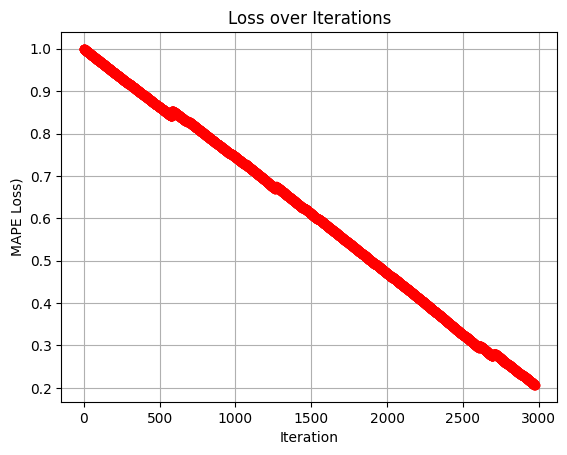

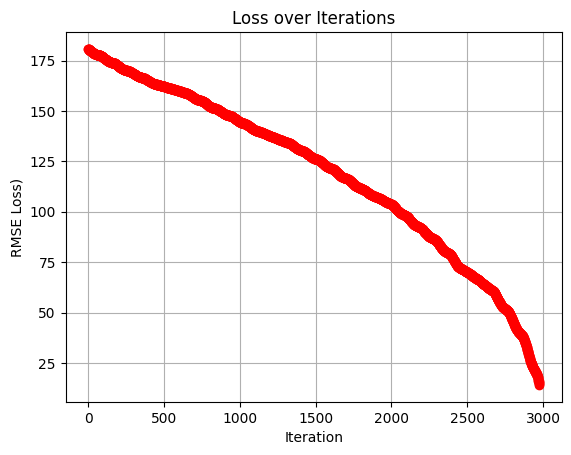

[[187.73656196 153.03542311 115.04932204 ... 112.48753172  40.77745424
   20.40406505]
 [ 13.71588826   7.10899519   7.81943817 ...   5.27476001   7.84877721
   11.09513448]
 [499.6574021  507.08656523 496.76542977 ... 380.57764486 401.12857227
  404.32089028]
 [  1.09908004   0.98956241   0.75365912 ...   0.67209864   0.77711289
    0.69936804]
 [ 13.19165466  11.01964575   9.65517347 ...   5.69719533   9.76077325
    1.9352358 ]
 [ 34.17682893  34.29598626  33.98239332 ...  35.60260739  35.97876285
   36.67673627]]
Running time: 376 seconds

(6, 2976)


<Figure size 1000x500 with 0 Axes>

starting prediction
Prediction time horizon (delta) = 1.

Prediction MAPE: 0.83091
Prediction RMSE: 93.0808



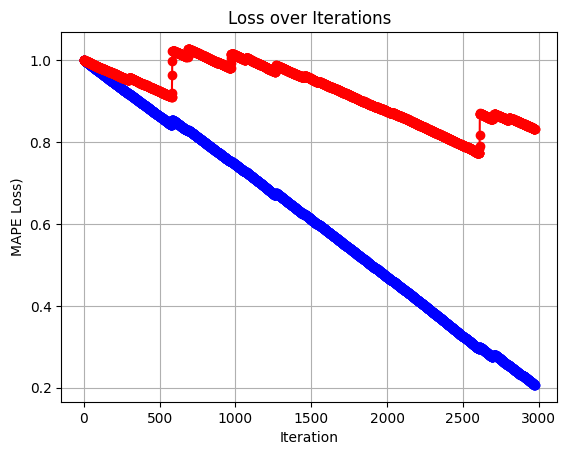

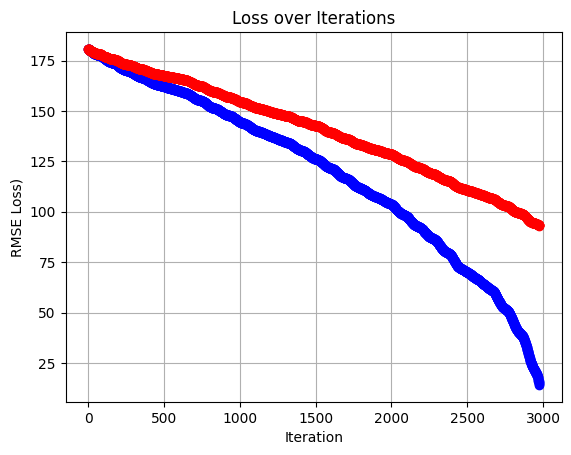

[[1.74799958e+02 1.73625058e+02 1.59206876e+02 ... 9.10087674e+01
  0.00000000e+00 0.00000000e+00]
 [1.13948608e+01 1.07481243e+01 1.04302287e+01 ... 7.90017065e+00
  7.12292818e+00 7.38683631e+00]
 [5.19477832e+02 4.56600630e+02 4.51635449e+02 ... 3.46227508e+02
  3.69452201e+02 3.37058383e+02]
 [7.51804724e-01 6.43886769e-01 5.93391155e-01 ... 4.53028236e-01
  3.76712684e-01 5.73787679e-01]
 [6.12051014e+00 1.01989303e+01 1.02163426e+01 ... 8.31692165e+00
  5.69336571e+00 6.03577136e+00]
 [2.44356916e+01 2.38269536e+01 2.00196029e+01 ... 1.59629477e+01
  9.51104211e+00 2.50723303e+01]]
Running time: 150 seconds

(6, 2976)


<Figure size 1000x500 with 0 Axes>

In [332]:
import scipy.io
import numpy as np
import time
import datetime as dt

# Assuming loaded_data is already prepared and is in the format of a dense matrix
dense_mat = building_data['uniform_series']  # Adjust this based on how you've prepared loaded_data

  # Assuming you want to work on a copy of the original data

list_of_arrays = [np.array(series) for series in dense_mat]
mape_values = []
rmse_values = []
# Stack these arrays vertically to form a 2D matrix
dense_mat_2d = np.vstack(list_of_arrays)
sparse_mat = dense_mat_2d.copy()
print("dense mat shape",dense_mat_2d.shape)
print(dense_mat_2d)
dense_mat_2d = np.where(dense_mat_2d == 'NaN', np.nan, dense_mat_2d).astype(float)
sparse_mat = np.where(sparse_mat == 'NaN', np.nan, sparse_mat).astype(float)

# Model Setting
rank = 20
pred_step = 2976 
time_lags = np.array([1, 4, 96])  
#time_lags = np.array([1, 96, 384])  # Adjust this based on the seasonality or patterns in your data#
burn_iter = 20
gibbs_iter = 5
multi_step = 1
dim1, dim2 = sparse_mat.shape
init = {"W": 0.1 * np.random.randn(dim1, rank), "X": 0.1 * np.random.randn(dim2, rank)}
print("starting prediction")
# Apply BTMF forecasting for different prediction time horizons (if needed)


start = time.time()
print('Prediction time horizon (delta) = {}.'.format(multi_step))
building_mat_hat, old_mape_values, old_rmse_values = BTMF_forecast(dense_mat_2d, sparse_mat, pred_step, multi_step, rank, time_lags, burn_iter, gibbs_iter)
plt.plot(old_mape_values, marker='o', color='red')
plt.title('Loss over Iterations')
plt.xlabel('Iteration')
plt.ylabel('MAPE Loss)')
plt.grid(True)
filename = "C:/Users/Rohit/Documents/Exeter-Placement/Results/mape_plot_" + dt.datetime.now().strftime('%Y%m%d_%H%M%S') + ".png"
plt.savefig(filename)
plt.show()

plt.plot(old_rmse_values, marker='o', color='red')
plt.title('Loss over Iterations')
plt.xlabel('Iteration')
plt.ylabel('RMSE Loss)')
plt.grid(True)
filename = "C:/Users/Rohit/Documents/Exeter-Placement/Results/rmse_plot_" + dt.datetime.now().strftime('%Y%m%d_%H%M%S') + ".png"
plt.savefig(filename)
plt.show()

print(building_mat_hat)
end = time.time()
print('Running time: %d seconds'%(end - start))
print()
print(building_mat_hat.shape)
plt.figure(figsize=(10, 5))


plt.tight_layout()
plt.show()

rank = 5
pred_step = 2976 
time_lags = np.array([1, 4, 96])  
#time_lags = np.array([1, 96, 384])  # Adjust this based on the seasonality or patterns in your data#
burn_iter = 20
gibbs_iter = 5
multi_step = 1
dim1, dim2 = sparse_mat.shape
init = {"W": 0.1 * np.random.randn(dim1, rank), "X": 0.1 * np.random.randn(dim2, rank)}
print("starting prediction")
# Apply BTMF forecasting for different prediction time horizons (if needed)
sparse_mat = mask_entries(sparse_mat, fraction=0.6)
start = time.time()
print('Prediction time horizon (delta) = {}.'.format(multi_step))
building_mat_hat, mape_values, rmse_values = new_BTMF_forecast(dense_mat_2d, sparse_mat, pred_step, multi_step, rank, time_lags, burn_iter, gibbs_iter)
plt.plot(old_mape_values, marker='o', color='blue')
plt.plot(mape_values, marker='o', color='red')
plt.title('Loss over Iterations')
plt.xlabel('Iteration')
plt.ylabel('MAPE Loss)')
plt.grid(True)
filename = "C:/Users/Rohit/Documents/Exeter-Placement/Results/mape_plot_" + dt.datetime.now().strftime('%Y%m%d_%H%M%S') + ".png"
plt.savefig(filename)
plt.show()
plt.plot(old_rmse_values, marker='o', color='blue')
plt.plot(rmse_values, marker='o', color='red')
plt.title('Loss over Iterations')
plt.xlabel('Iteration')
plt.ylabel('RMSE Loss)')
plt.grid(True)
filename = "C:/Users/Rohit/Documents/Exeter-Placement/Results/rmse_plot_" + dt.datetime.now().strftime('%Y%m%d_%H%M%S') + ".png"
plt.savefig(filename)
plt.show()

print(building_mat_hat)
end = time.time()
print('Running time: %d seconds'%(end - start))
print()
print(building_mat_hat.shape)
plt.figure(figsize=(10, 5))


plt.tight_layout()
plt.show()

In [333]:
# Read the .tsf file

"""
import pandas as pd

# Read the .tsf file

# Convert to DataFrame
loaded_data, frequency, forecast_horizon, contain_missing_values, contain_equal_length = convert_tsf_to_dataframe("C:/Users/Rohit/Documents/Exeter-Placement/Challenge/phase_1 data/phase_1_data/phase_1_data.tsf")
#print(loaded_data.shape,frequency, forecast_horizon, contain_missing_values, contain_equal_length)
solar_data = loaded_data[loaded_data['series_name'].str.contains('Solar')]
#print(building_data)
# 2. Determine the maximum starting timestamp among the buildings

max_start_timestamp = solar_data['start_timestamp'].max()
#print("max timestamp",max_start_timestamp)
solar_data['num_timestamps'] = solar_data['series_value'].apply(len)
#print(solar_data['num_timestamps'])
min_timestamps = solar_data['num_timestamps'].min()

# Trim each time series to have the same length as the shortest one
solar_data['uniform_series'] = solar_data['series_value'].apply(lambda x: x[-min_timestamps:])

# Update the 'num_timestamps' column to reflect the new uniform length
solar_data['num_timestamps'] = solar_data['uniform_series'].apply(len)
#print(solar_data['uniform_series'])
"""

'\nimport pandas as pd\n\n# Read the .tsf file\n\n# Convert to DataFrame\nloaded_data, frequency, forecast_horizon, contain_missing_values, contain_equal_length = convert_tsf_to_dataframe("C:/Users/Rohit/Documents/Exeter-Placement/Challenge/phase_1 data/phase_1_data/phase_1_data.tsf")\n#print(loaded_data.shape,frequency, forecast_horizon, contain_missing_values, contain_equal_length)\nsolar_data = loaded_data[loaded_data[\'series_name\'].str.contains(\'Solar\')]\n#print(building_data)\n# 2. Determine the maximum starting timestamp among the buildings\n\nmax_start_timestamp = solar_data[\'start_timestamp\'].max()\n#print("max timestamp",max_start_timestamp)\nsolar_data[\'num_timestamps\'] = solar_data[\'series_value\'].apply(len)\n#print(solar_data[\'num_timestamps\'])\nmin_timestamps = solar_data[\'num_timestamps\'].min()\n\n# Trim each time series to have the same length as the shortest one\nsolar_data[\'uniform_series\'] = solar_data[\'series_value\'].apply(lambda x: x[-min_timestamp

In [334]:
import scipy.io
import numpy as np
import time
import datetime
print("test starting")
# Convert to DataFrame
from datetime import datetime
from distutils.util import strtobool
import matplotlib.pyplot as plt
import pandas as pd

def convert_tsf_to_dataframe(full_file_path_and_name, replace_missing_vals_with="NaN", value_column_name="series_value",):
    col_names = []
    col_types = []
    all_data = {}
    line_count = 0
    frequency = None
    forecast_horizon = None
    contain_missing_values = None
    contain_equal_length = None
    found_data_tag = False
    found_data_section = False
    started_reading_data_section = False

    with open(full_file_path_and_name, "r", encoding="cp1252") as file:
        for line in file:
            # Strip white space from start/end of line
            line = line.strip()

            if line:
                if line.startswith("@"):  # Read meta-data
                    if not line.startswith("@data"):
                        line_content = line.split(" ")
                        if line.startswith("@attribute"):
                            if (
                                len(line_content) != 3
                            ):  # Attributes have both name and type
                                raise Exception("Invalid meta-data specification.")

                            col_names.append(line_content[1])
                            col_types.append(line_content[2])
                        else:
                            if (
                                len(line_content) != 2
                            ):  # Other meta-data have only values
                                raise Exception("Invalid meta-data specification.")

                            if line.startswith("@frequency"):
                                frequency = line_content[1]
                            elif line.startswith("@horizon"):
                                forecast_horizon = int(line_content[1])
                            elif line.startswith("@missing"):
                                contain_missing_values = bool(
                                    strtobool(line_content[1])
                                )
                            elif line.startswith("@equallength"):
                                contain_equal_length = bool(strtobool(line_content[1]))

                    else:
                        if len(col_names) == 0:
                            raise Exception(
                                "Missing attribute section. Attribute section must come before data."
                            )

                        found_data_tag = True
                elif not line.startswith("#"):
                    if len(col_names) == 0:
                        raise Exception(
                            "Missing attribute section. Attribute section must come before data."
                        )
                    elif not found_data_tag:
                        raise Exception("Missing @data tag.")
                    else:
                        if not started_reading_data_section:
                            started_reading_data_section = True
                            found_data_section = True
                            all_series = []

                            for col in col_names:
                                all_data[col] = []

                        full_info = line.split(":")

                        if len(full_info) != (len(col_names) + 1):
                            raise Exception("Missing attributes/values in series.")

                        series = full_info[len(full_info) - 1]
                        series = series.split(",")

                        if len(series) == 0:
                            raise Exception(
                                "A given series should contains a set of comma separated numeric values. At least one numeric value should be there in a series. Missing values should be indicated with ? symbol"
                            )

                        numeric_series = []

                        for val in series:
                            if val == "?":
                                numeric_series.append(replace_missing_vals_with)
                            else:
                                numeric_series.append(float(val))

                        if numeric_series.count(replace_missing_vals_with) == len(
                            numeric_series
                        ):
                            raise Exception(
                                "All series values are missing. A given series should contains a set of comma separated numeric values. At least one numeric value should be there in a series."
                            )

                        all_series.append(pd.Series(numeric_series).array)

                        for i in range(len(col_names)):
                            att_val = None
                            if col_types[i] == "numeric":
                                att_val = int(full_info[i])
                            elif col_types[i] == "string":
                                att_val = str(full_info[i])
                            elif col_types[i] == "date":
                                att_val = datetime.strptime(
                                    full_info[i], "%Y-%m-%d %H-%M-%S"
                                )
                            else:
                                raise Exception(
                                    "Invalid attribute type."
                                )  # Currently, the code supports only numeric, string and date types. Extend this as required.

                            if att_val is None:
                                raise Exception("Invalid attribute value.")
                            else:
                                all_data[col_names[i]].append(att_val)

                line_count = line_count + 1

        if line_count == 0:
            raise Exception("Empty file.")
        if len(col_names) == 0:
            raise Exception("Missing attribute section.")
        if not found_data_section:
            raise Exception("Missing series information under data section.")

        all_data[value_column_name] = all_series
        loaded_data = pd.DataFrame(all_data)

        return (
            loaded_data,
            frequency,
            forecast_horizon,
            contain_missing_values,
            contain_equal_length,
        )

from IPython.display import display
def new_BTMF_forecast(dense_mat, sparse_mat, pred_step, multi_step, 
                  rank, time_lags, burn_iter, gibbs_iter, option = "factor", gamma = 10):
    dim1, T = dense_mat.shape
    start_time = T - pred_step
    max_count = int(np.ceil(pred_step / multi_step))
    mat_hat = np.zeros((dim1, max_count * multi_step))
    mape_values=[]
    rmse_values=[]
    #f = IntProgress(min = 0, max = max_count) # instantiate the bar
    #display(f) # display the bar
    for t in range(max_count):
        if t == 0:
            init = {"W": 0.1 * np.random.randn(dim1, rank), "X": 0.1 * np.random.randn(start_time, rank)}
            mat, W, X_new, A, Sigma, tau = BTMF(dense_mat[:, 0 : start_time], 
                sparse_mat[:, 0 : start_time], init, rank, time_lags, burn_iter, gibbs_iter, multi_step, option)
        else:
            init = {"W_plus": W, "X_plus": X_new, "A_plus": A, "Sigma_plus": Sigma, "tau_plus": tau}
            mat, W, X_new, A, Sigma, tau = BTMF_partial(dense_mat[:, 0 : start_time + t * multi_step], 
                sparse_mat[:, 0 : start_time + t * multi_step], init, rank, time_lags, 
                burn_iter, gibbs_iter, multi_step, gamma)
            small_dense_mat = dense_mat[:, start_time : T]
            pos = np.where(small_dense_mat != 0)
            mape_value = compute_mape(small_dense_mat[pos], mat_hat[pos])
            mape_value_noisy = add_noise_to_loss(mape_value)
            mape_values.append(mape_value)
            rmse_value = compute_rmse(small_dense_mat[pos], mat_hat[pos])
            rmse_value_noisy = add_noise_to_loss(rmse_value)
            rmse_values.append(rmse_value)
        mat_hat[:, t * multi_step : (t + 1) * multi_step] = mat[:, - multi_step :]
        #f.value = t
    small_dense_mat = dense_mat[:, start_time : T]
    pos = np.where(small_dense_mat != 0)
    mape_value = compute_mape(small_dense_mat[pos], mat_hat[pos])
    rmse_value = compute_rmse(small_dense_mat[pos], mat_hat[pos])
    print('Prediction MAPE: {:.6}'.format(mape_value))
    print('Prediction RMSE: {:.6}'.format(rmse_value))
    print()
    return mat_hat, mape_values, rmse_values

def BTMF_forecast(dense_mat, sparse_mat, pred_step, multi_step, 
                  rank, time_lags, burn_iter, gibbs_iter, option = "factor", gamma = 10):
    dim1, T = dense_mat.shape
    start_time = T - pred_step
    max_count = int(np.ceil(pred_step / multi_step))
    mat_hat = np.zeros((dim1, max_count * multi_step))
    mape_values=[]
    rmse_values=[]
    #f = IntProgress(min = 0, max = max_count) # instantiate the bar
    #display(f) # display the bar
    for t in range(max_count):
        if t == 0:
            init = {"W": 0.1 * np.random.randn(dim1, rank), "X": 0.1 * np.random.randn(start_time, rank)}
            mat, W, X_new, A, Sigma, tau = BTMF(dense_mat[:, 0 : start_time], 
                sparse_mat[:, 0 : start_time], init, rank, time_lags, burn_iter, gibbs_iter, multi_step, option)
        else:
            init = {"W_plus": W, "X_plus": X_new, "A_plus": A, "Sigma_plus": Sigma, "tau_plus": tau}
            mat, W, X_new, A, Sigma, tau = BTMF_partial(dense_mat[:, 0 : start_time + t * multi_step], 
                sparse_mat[:, 0 : start_time + t * multi_step], init, rank, time_lags, 
                burn_iter, gibbs_iter, multi_step, gamma)
            small_dense_mat = dense_mat[:, start_time : T]
            pos = np.where(small_dense_mat != 0)
            mape_loss = compute_mape(small_dense_mat[pos], mat_hat[pos])  # or compute_mape, based on your preference
            mape_values.append(mape_loss)
            rmse_loss = compute_rmse(small_dense_mat[pos], mat_hat[pos])  # or compute_mape, based on your preference
            rmse_values.append(rmse_loss)
        mat_hat[:, t * multi_step : (t + 1) * multi_step] = mat[:, - multi_step :]
        #f.value = t
    small_dense_mat = dense_mat[:, start_time : T]
    pos = np.where(small_dense_mat != 0)
    mape_value = compute_mape(small_dense_mat[pos], mat_hat[pos])
    rmse_value = compute_rmse(small_dense_mat[pos], mat_hat[pos])
    print('Prediction MAPE: {:.6}'.format(mape_value))
    print('Prediction RMSE: {:.6}'.format(rmse_value))
    print()
    return mat_hat, mape_values, rmse_values
"""
loaded_data, frequency, forecast_horizon, contain_missing_values, contain_equal_length = convert_tsf_to_dataframe("C:/Users/Rohit/Documents/Exeter-Placement/Challenge/phase_1 data/phase_1_data/phase_1_data.tsf")

print(loaded_data)
#print(loaded_data.shape,frequency, forecast_horizon, contain_missing_values, contain_equal_length)
solar_data = loaded_data[loaded_data['series_name'].str.contains('solar')]

max_start_timestamp = solar_data['start_timestamp'].max()

solar_data['num_timestamps'] = solar_data['series_value'].apply(len)

min_timestamps = solar_data['num_timestamps'].min()

# Trim each time series to have the same length as the shortest one
solar_data['uniform_series'] = solar_data['series_value'].apply(lambda x: x[-min_timestamps:])

# Update the 'num_timestamps' column to reflect the new uniform length
solar_data['num_timestamps'] = solar_data['uniform_series'].apply(len)

# Assuming loaded_data is already prepared and is in the format of a dense matrix
dense_mat = solar_data['uniform_series']  # Adjust this based on how you've prepared loaded_data

loaded_data, frequency, forecast_horizon, contain_missing_values, contain_equal_length = convert_tsf_to_dataframe("C:/Users/Rohit/Documents/Exeter-Placement/Challenge/phase_1 data/phase_1_data/phase_1_data.tsf")

print(loaded_data)
#print(loaded_data.shape,frequency, forecast_horizon, contain_missing_values, contain_equal_length)
building_data = loaded_data[loaded_data['series_name'].str.contains('Solar')]

max_start_timestamp = building_data['start_timestamp'].max()

building_data['num_timestamps'] = building_data['series_value'].apply(len)

min_timestamps = building_data['num_timestamps'].min()

# Trim each time series to have the same length as the shortest one
building_data['uniform_series'] = building_data['series_value'].apply(lambda x: x[-min_timestamps:])

# Update the 'num_timestamps' column to reflect the new uniform length
building_data['num_timestamps'] = building_data['uniform_series'].apply(len)
  # Assuming you want to work on a copy of the original data

list_of_arrays = [np.array(series) for series in dense_mat]
mape_values = []
rmse_values = []
# Stack these arrays vertically to form a 2D matrix
dense_mat_2d = np.vstack(list_of_arrays)
sparse_mat = dense_mat_2d.copy()
print("dense mat shape",dense_mat_2d.shape)
print(dense_mat_2d)
dense_mat_2d = np.where(dense_mat_2d == 'NaN', np.nan, dense_mat_2d).astype(float)
sparse_mat = np.where(sparse_mat == 'NaN', np.nan, sparse_mat).astype(float)

# Model Setting
rank = 10
pred_step = 2976 
time_lags = np.array([1, 4, 96])  
#time_lags = np.array([1, 96, 384])  # Adjust this based on the seasonality or patterns in your data#
burn_iter = 50
gibbs_iter = 12
multi_step = 1
dim1, dim2 = sparse_mat.shape
init = {"W": 0.1 * np.random.randn(dim1, rank), "X": 0.1 * np.random.randn(dim2, rank)}
print("starting prediction")
# Apply BTMF forecasting for different prediction time horizons (if needed)

start = time.time()
print('Prediction time horizon (delta) = {}.'.format(multi_step))
building_mat_hat, mape_values, rmse_values = BTMF_forecast(dense_mat_2d, sparse_mat, pred_step, multi_step, rank, time_lags, burn_iter, gibbs_iter)
plt.plot(mape_values, marker='o', color='red')
plt.title('Loss over Iterations')
plt.xlabel('Iteration')
plt.ylabel('MAPE Loss)')
plt.grid(True)
filename = "C:/Users/Rohit/Documents/Exeter-Placement/Results/mape_plot_" + datetime.datetime.now().strftime('%Y%m%d_%H%M%S') + ".png"
plt.savefig(filename)
plt.show()

plt.plot(rmse_values, marker='o', color='red')
plt.title('Loss over Iterations')
plt.xlabel('Iteration')
plt.ylabel('RMSE Loss)')
plt.grid(True)
filename = "C:/Users/Rohit/Documents/Exeter-Placement/Results/rmse_plot_" + datetime.datetime.now().strftime('%Y%m%d_%H%M%S') + ".png"
plt.savefig(filename)
plt.show()

print(building_mat_hat)
end = time.time()
print('Running time: %d seconds'%(end - start))
print()
print(building_mat_hat.shape)
plt.figure(figsize=(10, 5))


plt.tight_layout()
plt.show()

import scipy.io
import numpy as np

# Assuming loaded_data is already prepared and is in the format of a dense matrix
dense_mat = solar_data['uniform_series']  # Adjust this based on how you've prepared loaded_data

  # Assuming you want to work on a copy of the original data

list_of_arrays = [np.array(series) for series in dense_mat]

# Stack these arrays vertically to form a 2D matrix
dense_mat_2d = np.vstack(list_of_arrays)
sparse_mat = dense_mat_2d.copy()
print("dense mat shape",dense_mat_2d.shape)
print(dense_mat_2d)
dense_mat_2d = np.where(dense_mat_2d == 'NaN', np.nan, dense_mat_2d).astype(float)
sparse_mat = np.where(sparse_mat == 'NaN', np.nan, sparse_mat).astype(float)

# Model Setting
rank = 10
pred_step = 2976  # You mentioned you want to predict the next 248 energy demand values
time_lags = np.array([1, 4, 96])  # Adjust this based on the seasonality or patterns in your data#
burn_iter = 2
gibbs_iter = 1
dim1, dim2 = sparse_mat.shape
init = {"W": 0.1 * np.random.randn(dim1, rank), "X": 0.1 * np.random.randn(dim2, rank)}

BTMFburn=2
BTMFgibbs=1
matrix, W_plus, X_plus, A_plus, Sigma_plus, tau_plus=BTMF(dense_mat_2d, sparse_mat, init, rank, time_lags, BTMFburn, BTMFgibbs, multi_step = 1, option = "factor")
print("matrix shape: ", matrix.shape)
print(matrix)

df = pd.DataFrame(matrix)  # Assuming mat_hat is your data matrix
df.to_csv('C:/Users/Rohit/Documents/Exeter-Placement/Results/solar_predicted_data.csv', index=False)

print("starting prediction")
# Apply BTMF forecasting for different prediction time horizons (if needed)
for multi_step in [4, 24, 48, 96, 672]:  # Adjust this list based on your requirements
    start = time.time()
    print('Prediction time horizon (delta) = {}.'.format(multi_step))
    solar_mat_hat = BTMF_forecast(dense_mat_2d, sparse_mat, pred_step, multi_step, rank, time_lags, burn_iter, gibbs_iter)
    print(solar_mat_hat)
    end = time.time()
    print('Running time: %d seconds'%(end - start))
    print()
print(solar_mat_hat.shape)
"""

test starting


'\nloaded_data, frequency, forecast_horizon, contain_missing_values, contain_equal_length = convert_tsf_to_dataframe("C:/Users/Rohit/Documents/Exeter-Placement/Challenge/phase_1 data/phase_1_data/phase_1_data.tsf")\n\nprint(loaded_data)\n#print(loaded_data.shape,frequency, forecast_horizon, contain_missing_values, contain_equal_length)\nsolar_data = loaded_data[loaded_data[\'series_name\'].str.contains(\'solar\')]\n\nmax_start_timestamp = solar_data[\'start_timestamp\'].max()\n\nsolar_data[\'num_timestamps\'] = solar_data[\'series_value\'].apply(len)\n\nmin_timestamps = solar_data[\'num_timestamps\'].min()\n\n# Trim each time series to have the same length as the shortest one\nsolar_data[\'uniform_series\'] = solar_data[\'series_value\'].apply(lambda x: x[-min_timestamps:])\n\n# Update the \'num_timestamps\' column to reflect the new uniform length\nsolar_data[\'num_timestamps\'] = solar_data[\'uniform_series\'].apply(len)\n\n# Assuming loaded_data is already prepared and is in the for

## Evaluation on Guangzhou Speed Data



**Scenario setting**:

- Tensor size: $214\times 61\times 144$ (road segment, day, time of day)
- Test on original data


In [335]:
import scipy.io
import warnings
warnings.simplefilter('ignore')

tensor = scipy.io.loadmat('C:/Users/Rohit/Documents/Exeter-Placement/transdim-master/datasets/Guangzhou-data-set/tensor.mat')['tensor']
dense_mat = tensor.reshape([tensor.shape[0], tensor.shape[1] * tensor.shape[2]])
sparse_mat = dense_mat.copy()

**Model setting**:

- Low rank: 10
- Total (rolling) prediction horizons: 7 * 144
- Time lags: {1, 2, 144, 144 + 1, 144 + 2, 7 * 144, 7 * 144 + 1, 7 * 144 + 2}
- The number of burn-in iterations: 1000
- The number of Gibbs iterations: 200

In [336]:
"""
import time
rank = 10
pred_step = 7 * 144
time_lags = np.array([1, 2, 3, 144, 145, 146, 7 * 144, 7 * 144 + 1, 7 * 144 + 2])
burn_iter = 10
gibbs_iter = 2
for multi_step in [2, 4, 6, 12, 18, 24, 30, 36, 42, 48, 54]:
    start = time.time()
    print('Prediction time horizon (delta) = {}.'.format(multi_step))
    mat_hat = BTMF_forecast(dense_mat, sparse_mat, pred_step, multi_step, rank, time_lags, burn_iter, gibbs_iter)
    end = time.time()
    print('Running time: %d seconds'%(end - start))
    print()
"""

"\nimport time\nrank = 10\npred_step = 7 * 144\ntime_lags = np.array([1, 2, 3, 144, 145, 146, 7 * 144, 7 * 144 + 1, 7 * 144 + 2])\nburn_iter = 10\ngibbs_iter = 2\nfor multi_step in [2, 4, 6, 12, 18, 24, 30, 36, 42, 48, 54]:\n    start = time.time()\n    print('Prediction time horizon (delta) = {}.'.format(multi_step))\n    mat_hat = BTMF_forecast(dense_mat, sparse_mat, pred_step, multi_step, rank, time_lags, burn_iter, gibbs_iter)\n    end = time.time()\n    print('Running time: %d seconds'%(end - start))\n    print()\n"